In [1]:
#import libraries
import numpy as np
import scipy as scp
from sklearn import tree
from sklearn import cross_validation
from sklearn import metrics
from sklearn import calibration
import matplotlib.pyplot as plt
import pandas
from pandas import DataFrame
import gzip
import re

%matplotlib inline

In [2]:
train_data_frame = pandas.read_csv("data\\train.csv", sep=",", quotechar='"')
test = pandas.read_csv("data\\test.csv", sep=",", quotechar='"')

# Extract year, day and hour and create "Year", "Month", "Hour" columns in train_data_frame

def parse_date(date):
    """
    maps date formatted as in training set as a list of [Year, Month, Hour]
    :param date: date as formatted in training set
    :retuap oject that can extract of Year, Month and Hour
    """
    mo=re.search(r'^([0-9]{4})-([0-9]{2})-[0-9]{2}\s+([0-9]{2}):[0-9]{2}:[0-9]{2}$',date)
    timelist = map(int,(mo.group(1),mo.group(2),mo.group(3)))
    return map(int,(mo.group(1),mo.group(2),mo.group(3)))

# Extract 'Year', 'Month' and 'Hour' columns for later use
train_data_frame['Year'],train_data_frame['Month'],train_data_frame['Hour'] = zip(*train_data_frame.loc[:,'Dates'].map(parse_date))
test['Year'],test['Month'],test['Hour'] = zip(*test.loc[:,'Dates'].map(parse_date))

#clean date : supress data outliers from dataframe
train_data_frame_ret = train_data_frame[train_data_frame.Y < 38]

In [3]:
def convertToSubmittable(prediction):
    """
    Transforms a column of predictions as a number associated to a Crime Category (between 0 and 38)
    into a dataframe filled with 0s except 1 coding the predicted Crime Category in the corresponding column
    :param prediction: 1 dimensional ndarray with values in [0:38]
    :return submittable: 2 dimensional ndarray with {columns : Crime Categories, rows : Predictions}
    """
    submittable = np.zeros((len(prediction),len(crimeCategoryList)))
    for i in range(len(prediction)):
        submittable[i][prediction[i]] = 1
    return submittable

    
def prepend(filename, line):
    """
    adds line to first column of first row of csv filename
    :type filename: String
    :type line: String
    :param filename: path to csv file
    :param line: String to be added
    """
    # r+ allows file to be read and written
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n')+ content)
        
def tocsv(submission,filename):
    """
    converts 2d dataframe or ndarray to csv file named filename
    :type submission: ndarray
    :param submision:that contains probabilities of belonging to various Crime Categories
    :param filename: path to csv file 
    """
    keys = np.unique(train_data_frame["Category"])
    DataFrame(dict(zip(keys, submission.T))).to_csv(filename)


def gzipcompress(filename):
    """
    compresses csv to gzip in same folder 
    :param filename: path to csv file
    """
    with open(filename, 'rb') as f_in:
        with gzip.open(filename[:-3]+"gz", 'wb') as f_out:
            f_out.writelines(f_in)

10 [-2.6156463894961961]
10010 [-2.6156463894961961, -2.6128878905674471]
20010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766]
30010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041]
40010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995]
50010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671]
60010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483]
70010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789]
80010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494

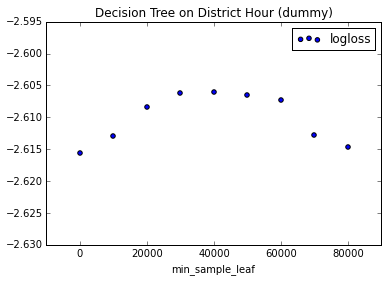

In [4]:
"""
Computes logloss for various min_sample_split
criterion : entropy 
features : Hour as dummy, PdDistrict as dummy
calibration : False
"""

df=pandas.get_dummies(train_data_frame_ret[["PdDistrict","Hour"]], columns = train_data_frame_ret[["Hour","PdDistrict"]])

scores = []
params = []
for k in range(10, 90000, 10000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="entropy")
    score = cross_validation.cross_val_score(treeClassifier, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores += [score.mean()]
    params += [k]
    print(k, scores)
    
plt.scatter(params,scores)

plt.title('Decision Tree on District Hour (dummy)')
plt.legend(["logloss"])
plt.xlabel("min_sample_leaf")

10 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494]
10010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494]
20010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494]
30010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494]
40010 [-2.6156463894961961, -2.6128878905674471, -2.6083169181357766, -2.6062577031363041, -2.6060648813205995, -2.6064191707296671, -2.607215819744483, -2.6127658063048789, -2.6146214978248494]
50010 [-2.6156463894961961, 

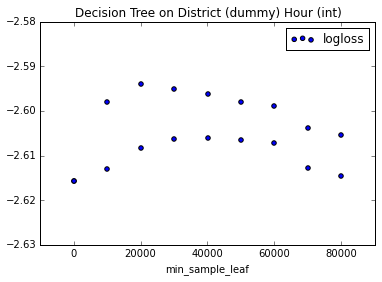

In [5]:
"""
Computes logloss for various min_sample_split
criterion : entropy 
features : Hour as int, PdDistrict as dummy
calibration : False
"""

df=pandas.get_dummies(train_data_frame_ret[["PdDistrict","Hour"]])

scores1 = []
params1 = []
for k in range(10, 90000, 10000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="entropy")
    score = cross_validation.cross_val_score(treeClassifier, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores1 += [score.mean()]
    params1 += [k]
    print(k, scores)
    
plt.scatter(params1,scores1)
plt.scatter(params,scores)

plt.title('Decision Tree on District (dummy) Hour (int)')
plt.legend(["logloss"])
plt.xlabel("min_sample_leaf")
plt.savefig("graphs\\loglosscurves\\PdDistrictHourEntropyUncal.pdf")

10 [-2.5932703256751859]
10010 [-2.5932703256751859, -2.5943509369773352]
20010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469]
30010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374]
40010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374, -2.6019308370800855]
50010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374, -2.6019308370800855, -2.6067926888326234]
60010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374, -2.6019308370800855, -2.6067926888326234, -2.6087824550652385]
70010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374, -2.6019308370800855, -2.6067926888326234, -2.6087824550652385, -2.610405411820174]
80010 [-2.5932703256751859, -2.5943509369773352, -2.5970864383695469, -2.5993481028049374, -2.6019308370800855, -2.6067926888326234, -2.6087824550652385, -2.610405411820174, -2.611150050910301

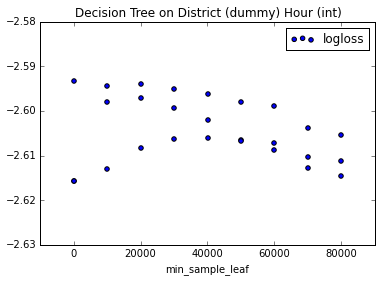

In [6]:
"""
Computes logloss for various min_sample_split
criterion : entropy 
features : Hour as int, PdDistrict as dummy
calibration : True
"""

df=pandas.get_dummies(train_data_frame_ret[["PdDistrict","Hour"]])

scores2 = []
params2 = []
for k in range(10, 90000, 10000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="gini")
    calibrator = calibration.CalibratedClassifierCV(treeClassifier)
    score = cross_validation.cross_val_score(calibrator, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores2 += [score.mean()]
    params2 += [k]
    print(k, scores2)
    
plt.scatter(params1,scores1)
plt.scatter(params,scores)
plt.scatter(params2,scores2)
plt.title('Decision Tree on District (dummy) Hour (int)')
plt.legend(["logloss"])
plt.xlabel("min_sample_leaf")
plt.savefig("graphs\\loglosscurves\\PdDistrictHourEntropy.pdf")

In [7]:
"""
Computes logloss for various min_sample_split
criterion : entropy 
features : Hour as dummy, PdDistrict as dummy
calibration : True
"""


df=pandas.get_dummies(train_data_frame_ret[["PdDistrict","Hour"]],columns = train_data_frame_ret[["PdDistrict","Hour"]])

scores3 = []
params3 = []
for k in range(10, 90000, 10000):
    treeClassifier = tree.DecisionTreeClassifier(min_samples_split=k, criterion="gini")
    calibrator = calibration.CalibratedClassifierCV(treeClassifier)
    score = cross_validation.cross_val_score(calibrator, df,
                                             np.ravel(train_data_frame_ret[["Category"]]),
                                             cv=5, scoring='log_loss')
    scores3 += [score.mean()]
    params3 += [k]
    print(k, scores3)
    
plt.scatter(params1,scores1)
plt.scatter(params,scores)
plt.scatter(params2,scores2)
plt.title('Decision Tree on District (dummy) Hour (int)')
plt.legend(["logloss"])
plt.xlabel("min_sample_leaf")

10 [-2.5932703256751859]
10010 [-2.5932703256751859, -2.5934955202915404]
20010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499]
30010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274]
40010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274, -2.6095558219350412]
50010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274, -2.6095558219350412, -2.6140961059291921]
60010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274, -2.6095558219350412, -2.6140961059291921, -2.6154239951078133]
70010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274, -2.6095558219350412, -2.6140961059291921, -2.6154239951078133, -2.61678483538922]
80010 [-2.5932703256751859, -2.5934955202915404, -2.5968321573850499, -2.6023266812786274, -2.6095558219350412, -2.6140961059291921, -2.6154239951078133, -2.61678483538922, -2.6176421184827192]

KeyboardInterrupt: 

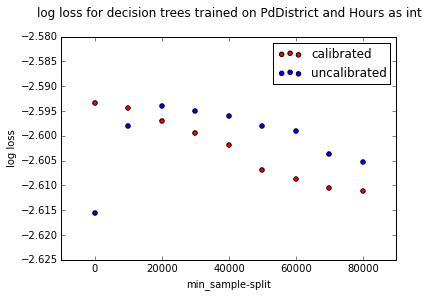

In [51]:
scores3bis=scores3[:-2]
params3bis=params3[:-2]
plt.scatter(params2,scores2, c='r', label="calibrated")
plt.scatter(params1,scores1, c='b', label = 'uncalibrated')
plt.title('log loss for decision trees trained on PdDistrict and Hours as int\n')
plt.xlabel("min_sample-split")
plt.ylabel("log loss")
plt.legend(bbox_to_anchor=(1, 1))


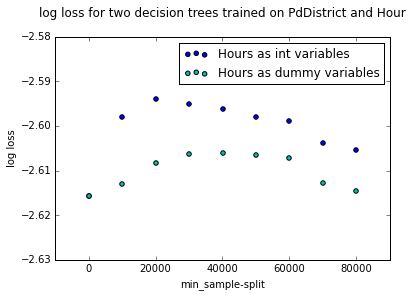

In [47]:
plt.scatter(params1,scores1, c='b', label = 'Hours as int variables')
plt.scatter(params,scores, c = 'c', label= "Hours as dummy variables")
plt.title('log loss for two decision trees trained on PdDistrict and Hour\n')
plt.xlabel("min_sample-split")
plt.ylabel("log loss")
plt.legend(bbox_to_anchor=(1, 1))